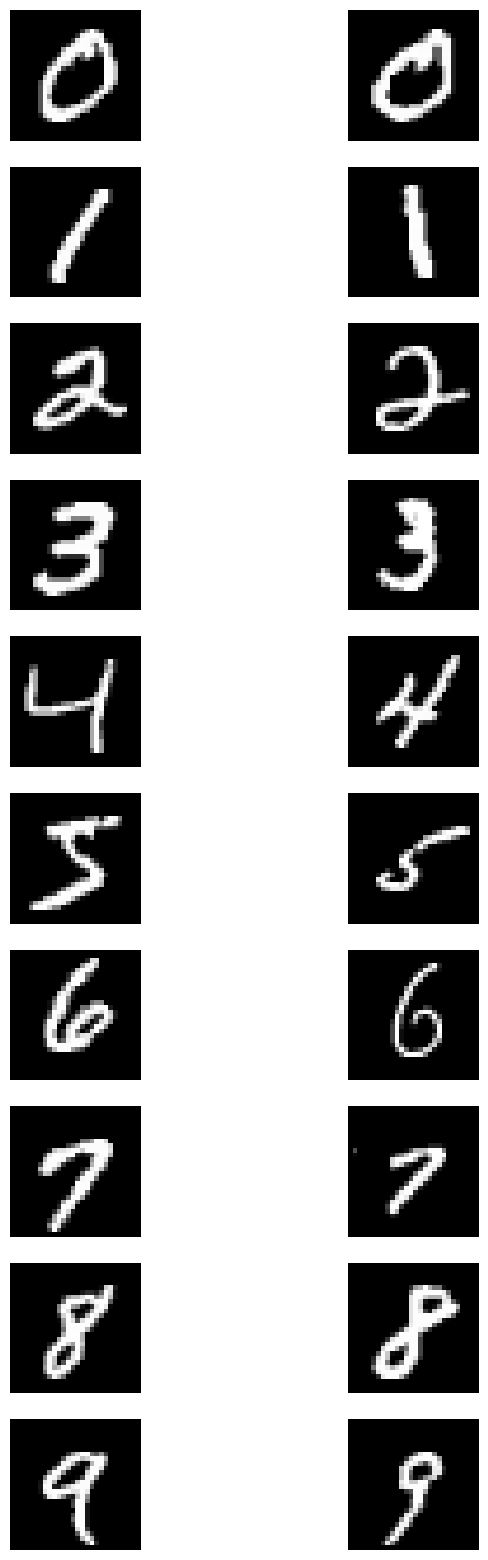

Percentage of variance covered by the first two principal components: 16.804573482860626
One-versus-one (OVO) classification report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1175
           1       0.95      0.98      0.96      1322
           2       0.89      0.91      0.90      1174
           3       0.88      0.92      0.90      1219
           4       0.93      0.95      0.94      1176
           5       0.91      0.88      0.89      1104
           6       0.97      0.95      0.96      1177
           7       0.94      0.93      0.93      1299
           8       0.91      0.87      0.89      1160
           9       0.92      0.89      0.90      1194

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000

One-versus-rest (OVR) classification report:
              precision    recall  f1-score   support

        

In [1]:




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from itertools import combinations


max_iterations = 10000
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

# Visualize two images of each class
def visualize_images(data):
    fig, axs = plt.subplots(10, 2, figsize=(8, 20))
    for i in range(10):
        for j in range(2):
            img = data[data['label'] == i].iloc[j, 1:].values.reshape(28, 28)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
    plt.show()

visualize_images(train_data)

# Split data
X_train, X_val, y_train, y_val = train_test_split(train_data.iloc[:, 1:], train_data['label'], test_size=0.2, random_state=42)

# Function to train and evaluate logistic regression model
def train_and_evaluate(X_train, y_train, X_val, y_val):
    model = LogisticRegression(max_iter=max_iterations)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))

# One-versus-one (OVO) classification
def ovo_classification(X_train, y_train, X_val, y_val):
    ovo_models = {}
    classes = np.unique(y_train)
    for pair in combinations(classes, 2):
        X_pair = X_train[(y_train == pair[0]) | (y_train == pair[1])]
        y_pair = y_train[(y_train == pair[0]) | (y_train == pair[1])]
        y_pair = np.where(y_pair == pair[0], 0, 1)
        model = LogisticRegression(max_iter=max_iterations)
        model.fit(X_pair, y_pair)
        ovo_models[pair] = model
    predictions = np.zeros((len(X_val), len(classes)))
    for pair, model in ovo_models.items():
        pred = model.predict(X_val)
        pred = np.where(pred == 0, pair[0], pair[1])
        predictions[:, pair[0]] += np.where(pred == pair[0], 1, 0)
        predictions[:, pair[1]] += np.where(pred == pair[1], 1, 0)
    y_pred = np.argmax(predictions, axis=1)
    print(classification_report(y_val, y_pred))

# One-versus-rest (OVR) classification
def ovr_classification(X_train, y_train, X_val, y_val):
    ovr_models = {}
    classes = np.unique(y_train)
    for cls in classes:
        y_cls = np.where(y_train == cls, 1, 0)
        model = LogisticRegression(max_iter=max_iterations)
        model.fit(X_train, y_cls)
        ovr_models[cls] = model
    predictions = np.zeros((len(X_val), len(classes)))
    for cls, model in ovr_models.items():
        proba = model.predict_proba(X_val)[:, 1]
        predictions[:, cls] = proba
    y_pred = np.argmax(predictions, axis=1)
    print(classification_report(y_val, y_pred))

# Perform PCA
pca = PCA(n_components=2)
pca.fit(X_train)
print("Percentage of variance covered by the first two principal components:", sum(pca.explained_variance_ratio_) * 100)

# Evaluate models
print("One-versus-one (OVO) classification report:")
ovo_classification(X_train, y_train, X_val, y_val)

print("One-versus-rest (OVR) classification report:")
ovr_classification(X_train, y_train, X_val, y_val)